## Pix2Pix Baseline Modeling

In [1]:
import cv2
import glob
import os
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import statistics

from skimage import data, img_as_float, img_as_ubyte, io, color, img_as_uint
from skimage.measure import compare_ssim
from skimage.measure import compare_mse, compare_nrmse
from get_data_splits_newdata import get_model_data_splits
# %pylab inline

In [2]:
"""
python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000


bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log0314_channel1_1000_jobout4.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000 --name cellvision0314_channel1_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512


"""

'\npython datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000\n\n\nbsub -gpu "num=1:mode=exclusive_process:mps=yes" -o log0314_channel1_1000_jobout4.txt python train.py --save_epoch_freq 50 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20190314-pix2pix/channel1_1000 --name cellvision0314_channel1_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0 --loadSize 512 --fineSize 512\n\n\n'

## Baseline metrics

In [12]:
def get_baseline_metrics():
    source_imgs_path = '/gpfs/data/lionnetlab/cellvision/gfpdata/20190314-single_img'

    channel4_img_paths = glob.glob('{}/amr_*_sample*_channel4.tif'.format(source_imgs_path))

    comp_channels = ['channel1', 'channel2', 'channel3']
#     comp_channels = ['channel1']
    
    comp_channel_ssims = []
    comp_channel_nmse = []
    for comp_channel in  comp_channels:
        print("Performing {} comparison".format(comp_channel))
        channel_ssims = []
        channel_nmses = []
        for channel4_img_path in channel4_img_paths:
            comp_channel_img_path = channel4_img_path.replace('channel4', comp_channel)
            channel_img_ft = io.imread(comp_channel_img_path).astype(np.uint)
            channel4_img_ft = io.imread(channel4_img_path).astype(np.uint)
            channel_img_ft = img_as_float(channel_img_ft)
            channel4_img_ft = img_as_float(channel4_img_ft)
            _min = channel4_img_ft.min()
            _max = channel4_img_ft.max()
            channel_ssim = compare_ssim(channel_img_ft, channel4_img_ft, data_range=_max-_min)
            channel_ssims.append(channel_ssim)
            channel_nmse = compare_nrmse(channel_img_ft, channel4_img_ft)
            channel_nmses.append(channel_nmse)
        channel_mean = statistics.mean(channel_ssims)
        channel_std = statistics.stdev(channel_ssims)
        channel_nmse = statistics.mean(channel_nmses)
        channel_nmse_std = statistics.stdev(channel_nmses)
        comp_channel_ssims.append( (comp_channel, channel_mean, channel_std) )
        comp_channel_nmse.append( (comp_channel, channel_nmse, channel_nmse_std) )
    print(comp_channel_ssims)
    print(comp_channel_nmse)
    return comp_channel_ssims, comp_channel_nmse

comp_channel_ssims, comp_channel_nmse = get_baseline_metrics()

Performing channel1 comparison
Performing channel2 comparison
Performing channel3 comparison
[('channel1', 0.744297228875404, 0.08465110919737869), ('channel2', 0.7717339251712705, 0.07640800906407565), ('channel3', 0.827188409609483, 0.06033681839175288)]
[('channel1', 6.856485573097715, 4.277760351806972), ('channel2', 4.966496650859768, 2.439559646579942), ('channel3', 2.579884234892866, 0.8367134473866227)]


No handles with labels found to put in legend.


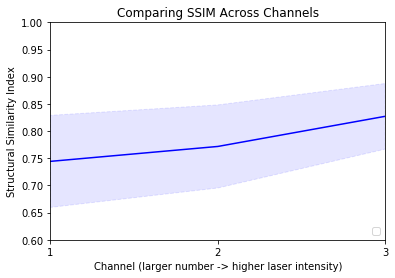

In [20]:
# Comparing SSIM
import operator
from numpy import array
ssim_means = array([x[1] for x in comp_channel_ssims])
ssim_stds = array([x[2] for x in comp_channel_ssims])

plt.plot(list(range(1, 4)), ssim_means, color='blue') 

plt.fill_between(list(range(1, 4)), ssim_means + ssim_stds, np.subtract(ssim_means, ssim_stds), 
                 color="blue", linestyle="--", alpha=0.1)


plt.title('Comparing SSIM Across Channels')
plt.legend(loc = 'lower right')
plt.ylim([.6, 1])
plt.xlim([1, 3])
plt.axes().set_xticks(list(range(1, 4)), minor=False)

plt.ylabel('Structural Similarity Index')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

No handles with labels found to put in legend.


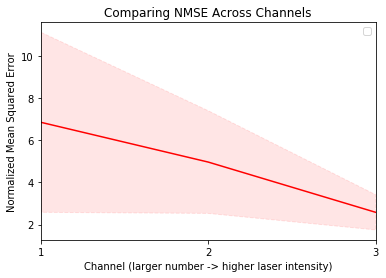

In [21]:
# Comparing MSE
import operator
from numpy import array
nmse_means = array([x[1] for x in comp_channel_nmse])
nmse_stds = array([x[2] for x in comp_channel_nmse])

plt.plot(list(range(1, 4)), nmse_means[0:5], color='red') 

plt.fill_between(list(range(1, 4)), nmse_means + nmse_stds, np.subtract(nmse_means, nmse_stds), 
                 color="red", linestyle="--", alpha=0.1)


plt.title('Comparing NMSE Across Channels')
plt.legend(loc = 'upper right')
# plt.ylim([0, 1])
plt.xlim([1, 3])
plt.axes().set_xticks(list(range(1, 4)), minor=False)

plt.ylabel('Normalized Mean Squared Error')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

## Pix2Pix output

In [35]:
def get_pix2pix_comps(channel, phase):
    comp_dir = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision0314_{}_1000/{}_latest/images'.format(channel, phase)
    real_B_channel_img_paths = glob.glob('{}/*real_B.png'.format(comp_dir, channel))
    channel_ssims = []
    channel_nmses = []
    for real_B_channel_img_path in real_B_channel_img_paths:
#         fake_B_channel_img_path = real_B_channel_img_path.replace('real_B', 'fake_B')
        fake_B_channel_img_path = real_B_channel_img_path.replace('real_B', 'real_A')
        real_B_img = io.imread(real_B_channel_img_path, cv2.COLOR_BGR2GRAY)
        fake_B_img = io.imread(fake_B_channel_img_path, cv2.COLOR_BGR2GRAY)
        real_B_img = img_as_float(real_B_img)
        fake_B_img = img_as_float(fake_B_img)
        _min = real_B_img.min()
        _max = real_B_img.max()
        channel_ssim = compare_ssim(fake_B_img, real_B_img, data_range=_max-_min)
        channel_ssims.append(channel_ssim)
        channel_nmse = compare_nrmse(fake_B_img, real_B_img)
        channel_nmses.append(channel_nmse)
    channel_mean = statistics.mean(channel_ssims)
    channel_std = statistics.stdev(channel_ssims)
    channel_nmse = statistics.mean(channel_nmses)
    channel_nmse_std = statistics.stdev(channel_nmses)
    return [ (channel, channel_mean, channel_std), (channel, channel_nmse, channel_nmse_std)]
    
something = get_pix2pix_comps('channel1', 'val')
print(something)

/gpfs/share/skynet/apps/anaconda3/envs/powerai1.6_env/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


[('channel1', 0.8157339340430382, 0.12459979664217741), ('channel1', inf, nan)]


/gpfs/share/skynet/apps/anaconda3/envs/powerai1.6_env/lib/python3.6/statistics.py:536: RuntimeWarning: invalid value encountered in double_scalars
  T, total, count = _sum((x-c)**2 for x in data)
/gpfs/share/skynet/apps/anaconda3/envs/powerai1.6_env/lib/python3.6/statistics.py:539: RuntimeWarning: invalid value encountered in double_scalars
  U, total2, count2 = _sum((x-c) for x in data)


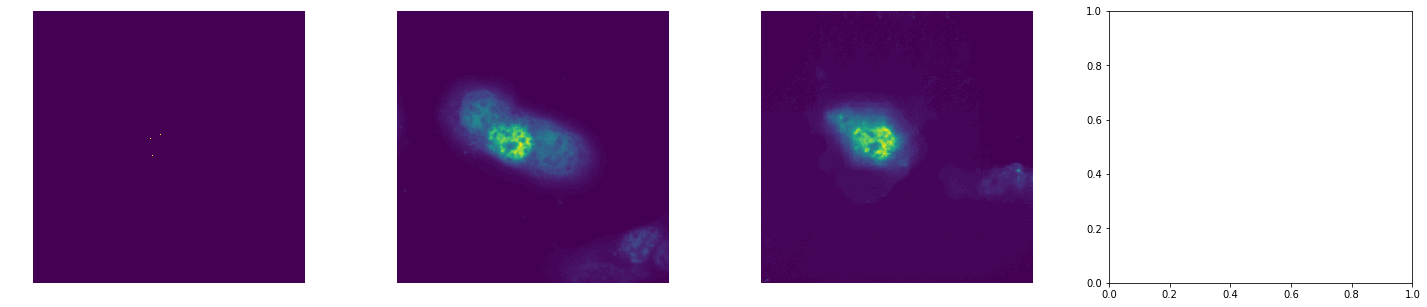

In [24]:

real_a_path = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision0314_channel1_1000/val_latest/images/amr_7_sample65_channel1_real_A.png'
real_a_img = io.imread(real_a_path, cv2.COLOR_BGR2GRAY)

real_b_path = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision0314_channel1_1000/val_latest/images/amr_7_sample65_channel1_real_B.png'
real_b_img = io.imread(real_b_path, cv2.COLOR_BGR2GRAY)

fake_b_path = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision0314_channel1_1000/val_latest/images/amr_7_sample65_channel1_fake_B.png'
fake_b_img = io.imread(fake_b_path, cv2.COLOR_BGR2GRAY)


fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(real_a_img);
ax[0].axis('off')
ax[1].imshow(real_b_img);
ax[1].axis('off')
ax[2].imshow(fake_b_img);
ax[2].axis('off')
# ax[3].imshow(cv_fold);
# ax[3].axis('off')
plt.show()